In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
import numpy as np
import tempfile
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
cwd = "/Workspace/Shared"

# Example: Image Segmentation
## Build segmentation

In [4]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=15,
                                      width_shift_range=0.25,
                                      height_shift_range=0.25,
                                      zoom_range=[0.3, 1.25],
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=15,
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       zoom_range=[0.3, 1.25],
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [5]:
from PIL import Image
from os import listdir
from os.path import isfile, join

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, which_subset, subset_filenames, out_shape, img_generator=None, mask_generator=None, preprocessing_function=None):
        self.which_subset = which_subset
        self.img_generator = img_generator
        self.mask_generator = mask_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape
        self.subset_filenames = subset_filenames

    def __len__(self):
        return len(self.subset_filenames)
    
    def read_rgb_mask(self, img_path):
        '''
        img_path: path to the mask file
        Returns the numpy array containing target values
        '''

        mask_img = Image.open(img_path)
        #mask_img = mask_img.resize(self.out_shape, resample=Image.NEAREST)
        mask_arr = np.array(mask_img)
        
        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    
        # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
 
        return new_mask_arr
    
    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(curr_filename)
        #mask = Image.open(os.path.join(self.dataset_dir, 'Masks', curr_filename.replace("jpg", "png")))
        mask = self.read_rgb_mask(curr_filename.replace("jpg", "png").replace("Images", "Masks"))
        # Resize image and mask
        #img = img.resize(self.out_shape)

        img_arr = np.array(img)
        mask_arr = mask

        # in this dataset 255 mask label is assigned to an additional class, which corresponds 
        # to the contours of the objects. We remove it for simplicity.
        #mask_arr[mask_arr == 255] = 0
        mask_arr = np.expand_dims(mask_arr, -1)
        if self.which_subset == 'training':
            if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
                mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
                img_arr = self.img_generator.apply_transform(img_arr, img_t)
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
                out_mask = np.zeros_like(mask_arr)
                for c in np.unique(mask_arr):
                    if c > 0:
                        curr_class_arr = np.float32(mask_arr == c)
                        curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
                        # from [0, 1] to {0, 1}
                        curr_class_arr = np.uint8(curr_class_arr)
                        # recover original class
                        curr_class_arr = curr_class_arr * c 
                        out_mask += curr_class_arr
                
        else:
            out_mask = mask_arr

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
            
        return img_arr/255., np.float32(out_mask)

In [6]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from glob import glob
img_h = 768
img_w = 1024

filenames = glob(os.path.join(cwd, 'Development_Dataset', 'Training', "Bipbip", "Mais", "Images", "*"))
#filenames += glob(os.path.join(cwd, 'Development_Dataset', 'Training', "Roseau", "Mais", "Images", "*"))
#filenames += glob(os.path.join(cwd, 'Development_Dataset', 'Training', "Weedelec", "Mais", "Images", "*"))
import random
random.seed(SEED)
random.shuffle(filenames)

training_filenames = filenames[:(int)(0.8*len(filenames))]
validation_filenames = filenames[(int)(0.8*len(filenames)):]

dataset = CustomDataset('training', training_filenames, out_shape=[img_w, img_h], img_generator=img_data_gen, mask_generator=mask_data_gen, preprocessing_function=preprocess_input)
dataset_valid = CustomDataset('validation', validation_filenames, out_shape=[img_w, img_h], preprocessing_function=preprocess_input)

In [7]:
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split

X = np.zeros(shape=(len(filenames), img_h , img_w, 3))
Y = np.zeros(shape=(len(filenames), img_h, img_w, 1))

from PIL import Image
def read_rgb_mask(img_path):
        '''
        img_path: path to the mask file
        Returns the numpy array containing target values
        '''

        mask_img = Image.open(img_path)
        mask_img = mask_img.resize([img_w, img_h], resample=Image.NEAREST)
        mask_arr = np.array(mask_img)
        
        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

        # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
 
        return new_mask_arr
n = 0
for path in filenames:
    img = imread(path)[:,:,:3]
    img = resize(img, (img_h, img_w), mode='constant', preserve_range=True)
    X[n] = preprocess_input(img)
    #X[n] = img/255.0
    mask = np.zeros((img_h, img_w, 3), dtype=np.bool)
    mask = read_rgb_mask(path.replace("jpg", "png").replace("Images", "Masks"))
    mask = np.expand_dims(mask, -1)
    mask = np.float32(mask)
    Y[n] = mask
    n = n + 1

x_train = X
y_train = Y
print(x_train.shape)
print(x_train[0].shape)
print(y_train.shape)
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state=SEED)

(90, 768, 1024, 3)
(768, 1024, 3)
(90, 768, 1024, 1)


In [8]:
batch_size = 1

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.repeat()

In [9]:
valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(batch_size)

valid_dataset = valid_dataset.repeat()

In [8]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1536, 2048, 3)
(1, 1536, 2048, 1)


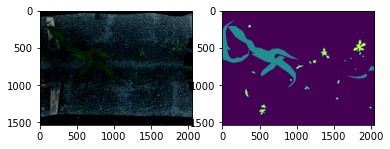

In [11]:
import sys
import numpy
iterator = iter(valid_dataset)
numpy.set_printoptions(threshold=sys.maxsize)
augmented_img, target = next(iterator)
print(augmented_img.shape)
print(target.shape)
for i in range(0,batch_size):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(augmented_img[i])
    ax[1].imshow(target[i])

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


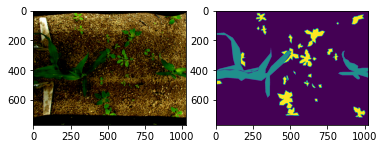

In [9]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_train[30])
ax[1].imshow(y_train[30])

plt.show()

In [10]:
def compute_segmentation_masks_count(img_path):
        '''
        img_path: path to the mask file
        Returns the numpy array containing target values
        '''

        mask_img = Image.open(img_path)
        mask_img = mask_img.resize([img_h, img_w], resample=Image.NEAREST)
        mask_arr = np.array(mask_img)
        
        new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    
        # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
        new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
        new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
        new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
        
        unique, counts = np.unique(new_mask_arr, return_counts=True)
        while len(counts) < 3:
            counts = np.append(counts, [1])
        return counts

def compute_weight_unbalance_mean(filenames):
        counts = np.array([0, 0, 0], dtype=np.float64)
        for img_path in filenames:
            count = compute_segmentation_masks_count(img_path.replace("jpg", "png").replace("Images", "Masks"))
            count_norm = count / np.linalg.norm(count)
            count_norm[1] = count_norm[0] / count_norm[1]
            count_norm[2] = count_norm[0] / count_norm[2]
            counts += count_norm
        classes = [0, 1, 2]
        return dict(zip(classes, counts/len(filenames)))
    
def compute_weight_unbalance_matrix(filenames):
        counts = []
        for img_path in filenames:
            count = compute_segmentation_masks_count(img_path.replace("jpg", "png").replace("Images", "Masks"))
            count_norm = count / np.linalg.norm(count)
            count_norm[1] = count_norm[0] / count_norm[1]
            count_norm[2] = count_norm[0] / count_norm[2]
            counts.append(count_norm)
        return np.asarray(counts)
    
class_weights = compute_weight_unbalance_mean(filenames)
sample_weights = compute_weight_unbalance_matrix(filenames)
print(class_weights)
print(np.fromiter(class_weights.values(), dtype=np.float64))
print(sample_weights)
from itertools import cycle
sample_weights_iterator = cycle(sample_weights)

{0: 0.9905849482935153, 1: 12.179596731690367, 2: 68.3102412220077}
[ 0.99058495 12.17959673 68.31024122]
[[9.82198355e-01 1.37413861e+01 5.65403482e+00]
 [9.90833632e-01 7.49260915e+00 3.59198536e+01]
 [9.96036922e-01 1.23016845e+01 2.70615284e+01]
 [9.94790831e-01 1.06410288e+01 2.44788767e+01]
 [9.83610640e-01 1.04647230e+01 6.39255256e+00]
 [9.73072688e-01 1.22723314e+01 4.49598211e+00]
 [9.93387249e-01 8.69329217e+00 8.92028615e+01]
 [9.96963914e-01 1.38441737e+01 3.36641981e+01]
 [9.82393589e-01 1.43194634e+01 5.65340252e+00]
 [9.92086876e-01 9.80503302e+00 1.33458427e+01]
 [9.96453895e-01 1.18431382e+01 1.42382908e+03]
 [9.98088840e-01 1.64611896e+01 8.36622161e+01]
 [9.90825368e-01 7.51961024e+00 3.29737587e+01]
 [9.96671961e-01 1.22508973e+01 1.94108369e+02]
 [9.90487167e-01 7.22893211e+00 7.79421563e+01]
 [9.98624841e-01 2.18205006e+01 3.90507555e+01]
 [9.68492877e-01 5.49110696e+00 5.50836223e+00]
 [9.75534596e-01 5.34584702e+00 7.95682087e+00]
 [9.90344132e-01 7.33660636e+0

In [11]:
model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

#adding dropout and L2 regularization
def add_regularizations(model, dropout_after, regularizer=tf.keras.regularizers.l2(0.01)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model
    
    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr): #apply also to vgg?
                setattr(layer, attr, regularizer)
                
    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    
    updated_model = Sequential()
    for layer in model.layers:
        updated_model.add(layer)
        if dropout_after in layer.name:
            updated_model.add(Dropout(.2))

    model = updated_model
            
    return model

model.summary()
#for layer in vgg.layers:
#    layer.trainable = False

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 1030, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 384, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 386, 514, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [12]:
def create_model(model_input, depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(model_input)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal()))
        model.add(tf.keras.layers.LeakyReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    
    return model

In [13]:
model = create_model(model, depth=5, 
                     start_f=8, 
                     num_classes=3)

model = add_regularizations(model, "leaky")
print(model.losses)
# Visualize created model as a table
model.summary()
# Visualize initialized weights
# model.weights

[<tf.Tensor: shape=(), dtype=float32, numpy=4.5555096>, <tf.Tensor: shape=(), dtype=float32, numpy=1.7125463>, <tf.Tensor: shape=(), dtype=float32, numpy=0.85442>, <tf.Tensor: shape=(), dtype=float32, numpy=0.42719063>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21039182>, <tf.Tensor: shape=(), dtype=float32, numpy=0.039953962>]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 24, 32, 2048)      58331648  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 48, 64, 2048)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 64, 256)       4718848   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 64, 256)       0         
___________________________________________________

## Prepare the model for training

In [14]:
from tensorflow.keras import backend as K
def weightedLoss(originalLossFunc):

    def lossFunc(true, pred):

        axis = -1
        classSelectors = true
        weightsList = next(sample_weights_iterator)
        
        classSelectors = [K.equal(tf.cast(i, tf.float32), classSelectors) for i in range(len(weightsList))]

        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
        
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]

        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
        # Get prediction and target related to only a single class (i)
        class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
        class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
        intersection = tf.reduce_sum(class_true * class_pred)
        union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
        iou = (intersection + 1e-7) / (union + 1e-7)
        per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=weightedLoss(loss), metrics=metrics)

## Training with callbacks

In [15]:
callbacks = []

rlp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", min_delta=0.001, patience=3, factor=0.1)
callbacks.append(rlp_callback)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks.append(es_callback)

history = model.fit(x=X_train, y=Y_train,
          epochs=200,
          batch_size=1,
          shuffle=False, #for weighted customized loss
          validation_data=(X_valid, Y_valid), 
          callbacks=callbacks)

Epoch 1/200
72/72 [==============================] - 33s 457ms/step - loss: 8.3643 - accuracy: 0.9029 - meanIoU: 0.3773 - val_loss: 7.2264 - val_accuracy: 0.9374 - val_meanIoU: 0.4552 - lr: 1.0000e-04
Epoch 2/200
72/72 [==============================] - 34s 467ms/step - loss: 6.6800 - accuracy: 0.9463 - meanIoU: 0.5664 - val_loss: 6.0665 - val_accuracy: 0.9541 - val_meanIoU: 0.5892 - lr: 1.0000e-04
Epoch 3/200
72/72 [==============================] - 32s 438ms/step - loss: 5.6782 - accuracy: 0.9557 - meanIoU: 0.6243 - val_loss: 5.2027 - val_accuracy: 0.9589 - val_meanIoU: 0.6175 - lr: 1.0000e-04
Epoch 4/200
72/72 [==============================] - 30s 417ms/step - loss: 4.8836 - accuracy: 0.9606 - meanIoU: 0.6518 - val_loss: 4.4994 - val_accuracy: 0.9610 - val_meanIoU: 0.6353 - lr: 1.0000e-04
Epoch 5/200
72/72 [==============================] - 30s 418ms/step - loss: 4.2104 - accuracy: 0.9646 - meanIoU: 0.6812 - val_loss: 3.8909 - val_accuracy: 0.9630 - val_meanIoU: 0.6785 - lr: 1.0000

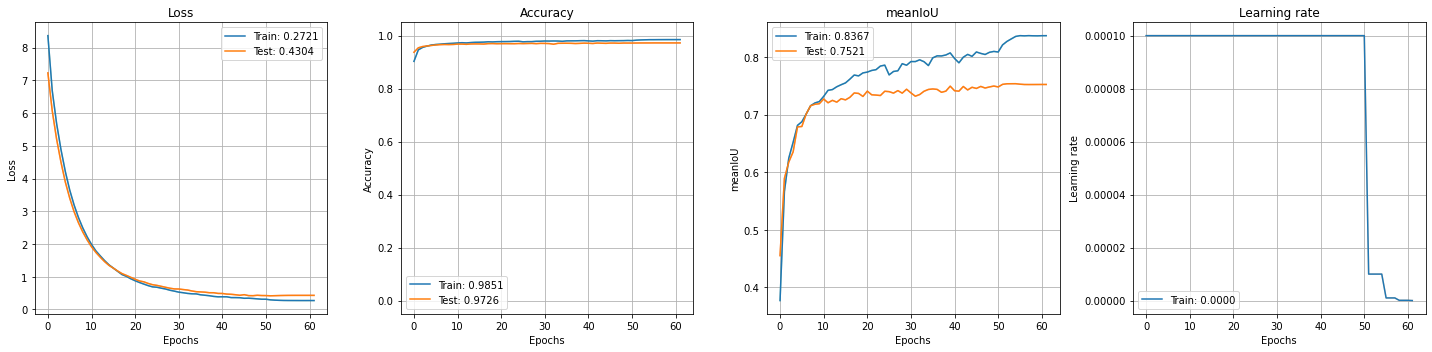

In [16]:
from plot_keras_history import plot_history
plot_history(history.history)

In [17]:
model.save('model_test_new_preprocess_fine_tuning_resnet152v2.h5')

## Test model

## Compute prediction

In [19]:
model.load_weights('/multiclass_segmentation_experiments/CNN_Nov27_08-41-36/ckpts/cp_02.ckpt')

ValueError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /multiclass_segmentation_experiments/CNN_Nov27_08-41-36/ckpts/cp_02.ckpt: Not found: /multiclass_segmentation_experiments/CNN_Nov27_08-41-36/ckpts; No such file or directory

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
    target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
    prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)